In [1]:
from SimPEG import *
from discretize import TensorMesh
from simpegEM1D.simulation import EM1DFMSimulation
from simpegEM1D.survey import EM1DSurveyFD
from simpegEM1D.sources import *
from simpegEM1D.receivers import *
from simpegEM1D import analytics, Utils1D
from simpegEM1D.EM1DSimulation import *
from scipy.constants import mu_0
import numpy as np
%pylab inline

Populating the interactive namespace from numpy and matplotlib


In [2]:
rx_location = np.array([7.86, 0., 100.+30.])
src_location = np.array([0., 0., 100.+30.])
rx_location2 = np.array([7.86, 0., 100.+35.])
src_location2 = np.array([0., 0., 100.+35.])

frequency = np.array([382, 1822, 7970, 35920, 130100], dtype=float)
I = 1.
a = 1.
field_type = "ppm"

# Receiver list
receiver_list = [
    HarmonicPointReceiver(
        rx_location, frequency, orientation="z", field_type=field_type, component="real"
    )
]
receiver_list.append(
    HarmonicPointReceiver(
        rx_location, frequency, orientation="z", field_type=field_type, component="imag"
    )
)


receiver_list2 = [
    HarmonicPointReceiver(
        rx_location2, frequency, orientation="z", field_type=field_type, component="real"
    )
]
receiver_list2.append(
    HarmonicPointReceiver(
        rx_location2, frequency, orientation="z", field_type=field_type, component="imag"
    )
)


# Sources
source_list = [
    HarmonicMagneticDipoleSource(
        receiver_list=receiver_list, location=src_location, orientation="z", I=I
    )
]

source_list.append(
    HarmonicMagneticDipoleSource(
        receiver_list=receiver_list2, location=src_location2, orientation="z", I=I
    )
)



# source_list = [
#     HarmonicHorizontalLoopSource(
#         receiver_list=receiver_list, location=src_location, a=a, I=I
#     )
# ]

# Survey
FDsurvey = EM1DSurveyFD(source_list)
nSrc = FDsurvey.nSrc

In [3]:
sig_half = 1e-1
sig_blk = 1e0

hz = get_vertical_discretization_frequency(frequency, sigma_background=sig_half)
mesh1D = set_mesh_1d(hz)
depth = -mesh1D.gridN[:-1]
LocSigZ = -mesh1D.gridCC
nlay = depth.size
topo = np.r_[0., 0., 100.]

chi_half = 0.
wires = maps.Wires(('sigma', mesh1D.nC),('h', nSrc))
expmap = maps.ExpMap(mesh1D)
# expmap_h = Maps.ExpMap(nP=1)
sigmaMap = expmap * wires.sigma
# hMap = expmap_h*wires.h
sig  = np.ones(mesh1D.nC)*sig_half
blk_ind = (-20>LocSigZ) & (-40<LocSigZ)
sig[blk_ind] = sig_blk
if nSrc == 1:
    h_true = src_location[2] - topo[2]
    m_true = np.r_[np.log(sig), h_true]
    m_true_dh = np.r_[np.log(sig), h_true + 5.]
else:
    h_true = np.r_[src_location[2], src_location2[2]] - topo[2]
    m_true = np.r_[np.log(sig), h_true]
    m_true_dh = np.r_[np.log(sig), h_true + 5.]
        


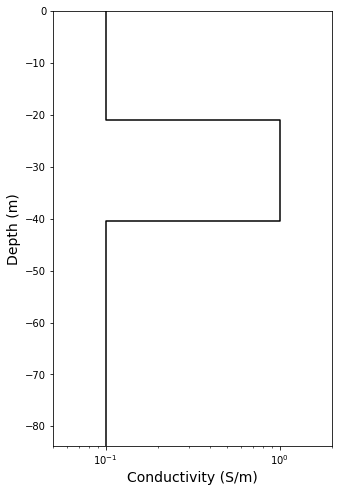

In [4]:
fig, ax = subplots(1,1, figsize=(5, 8))
Utils1D.plotLayer(sig, mesh1D, showlayers=False)

In [5]:
sim = EM1DFMSimulation(
    survey=FDsurvey, thicknesses=hz, sigmaMap=sigmaMap, hMap=wires.h,
    chi= np.zeros(nlay)
)
  
d_true = sim.dpred(m_true)
# d_p = FDsurvey.dpred(m_dx_p)
# d_n = FDsurvey.dpred(m_dx_n)
d_dh = sim.dpred(m_true_dh)
# J_h_diff = (d_p-d_n) / (dh)
# plt.plot(J_h_diff, 'k')
# plt.plot(prob.getJ_height(m_true), 'bx')

ValueError: operands could not be broadcast together with shapes (19,5) (20,5) 

In [ ]:
fig, axes = plt.subplots(1,1, figsize = (7,5))
if nSrc == 1:
    axes.plot(frequency, d_true[0:len(frequency)], 'k.-')
    axes.plot(frequency, d_true[len(frequency):], 'b.-')
    axes.plot(frequency, d_dh[0:len(frequency)], 'kx')
    axes.plot(frequency, d_dh[len(frequency):], 'bx')
else:
    axes.plot(frequency, d_true[0:len(frequency)], 'k.-')
    axes.plot(frequency, d_true[len(frequency):2*len(frequency)], 'b.-')
    axes.plot(frequency, d_dh[0:len(frequency)], 'kx')
    axes.plot(frequency, d_dh[len(frequency):2*len(frequency)], 'bx')
        
axes.set_xscale('log')

In [ ]:
from SimPEG import regularization, data

In [ ]:
std = 0.07
floor = 0.
np.random.seed(1)
uncert = std*abs(d_true)+floor
noise = std*np.abs(d_true)*np.random.randn(len(d_true))
d_obs = d_true + noise
dataObj = data.Data(FDsurvey, dobs=d_obs, noise_floor=uncert)

dmisfit = data_misfit.L2DataMisfit(dataObj, sim)
dmisfit.W = utils.sdiag(1/uncert)


In [ ]:
m0 = np.r_[np.log(np.ones_like(sig)*sig_half), 45.*np.ones(nSrc)]

reg_sigma = regularization.Sparse(
    mesh1D, mapping=wires.sigma, cell_weights=mesh1D.vol,
    alpha_s = 0.01
)
p=0.
qx, qz = 1., 1.
reg_sigma.norms = np.c_[p, qx, qz, 0.]
IRLS = directives.Update_IRLS(
    max_irls_iterations=20, minGNiter=1, fix_Jmatrix=True, coolingRate=2, 
    beta_tol=1e-2,
    chifact_start = 1.
)

mesh_h = TensorMesh([np.ones(nSrc)])
reg_h = regularization.Sparse(
    mesh_h, mapping=wires.h, 
    alpha_s = 1.
)
reg = reg_sigma + reg_h
opt = optimization.ProjectedGNCG(maxIter = 40)
opt.maxIterLS = 5
invProb = inverse_problem.BaseInvProblem(dmisfit, reg, opt)
beta = directives.BetaSchedule(coolingFactor=2, coolingRate=2)
betaest = directives.BetaEstimate_ByEig(beta0_ratio=1.)
target = directives.TargetMisfit()
update_sense = directives.UpdateSensitivityWeights()
inv = inversion.BaseInversion(invProb, directiveList=[beta,betaest,target])
# inv = Inversion.BaseInversion(invProb, directiveList=[IRLS, betaest])
# inv = Inversion.BaseInversion(invProb, directiveList=[IRLS])

# prob.counter = opt.counter = utils.Counter()
opt.LSshorten = 0.5
opt.remember('xc')


In [ ]:
print(np.shape(sim.getJ_sigma(m0)))
print(np.shape(sim.getJ_height(m0)))
print(sim.getJ_height(m0))

In [ ]:
mopt = inv.run(m0)

In [ ]:
print (wires.h*m0)
print (wires.h*mopt)
print (sim.h)

In [ ]:
%pylab inline
fig, ax = subplots(1,1, figsize=(5, 8))
Utils1D.plotLayer(sig, mesh1D, showlayers=False)
Utils1D.plotLayer(sigmaMap*mopt, mesh1D, showlayers=True, **{'color':'r'})
# Utils1D.plotLayer(sigmaMap*invProb.l2model, LocSigZ, showlayers=True,**{'color':'g'})

In [ ]:
fig, axes = subplots(1,1, figsize = (7,5))
if nSrc == 1:
    axes.plot(frequency, d_true[0:len(frequency)], 'k.-')
    axes.plot(frequency, d_true[len(frequency):], 'b.-')
    axes.plot(frequency, d_obs[0:len(frequency)], 'kx')
    axes.plot(frequency, d_obs[len(frequency):], 'bx')
else:
    axes.plot(frequency, d_true[0:len(frequency)], 'k.-')
    axes.plot(frequency, d_true[len(frequency):2*len(frequency)], 'b.-')
    axes.plot(frequency, d_obs[0:len(frequency)], 'kx')
    axes.plot(frequency, d_obs[len(frequency):2*len(frequency)], 'bx')
axes.set_xscale('log')
axes.set_xlabel